## HACK THE TRAIL

In [324]:
# Main Imports
import re
import requests
import pandas as pd
import numpy as np
from scipy import stats

import json
import time
import string
import warnings
from datetime import timedelta

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cufflinks as cf
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
import plotly.plotly as py

#Scraping
from bs4 import BeautifulSoup

## Forecasting
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

#Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# 1. Import Data

## 1.1 Import data from Tableau

In [735]:
# Import data after join and pivot traffic columns
df_trails = pd.read_csv('./data/Daily_withNulls+Weather_clean.csv')

In [736]:
df_trails.head()

,Temp Delta,Weekday,Avg Date,Date,Name,Number of Records,Prcp,Trails,Traffic,Station,Tmax,Tmin,Time
0,31.0,7,6939.571429,3/23/19,"AUSTIN GREAT HILLS, TX US",1,0.0,Butler Trail: North Congress - Urban Trail,4601.0,USC00410433,80.0,49.0,3/23/19 0:00
1,33.0,6,6939.571429,3/22/19,"AUSTIN GREAT HILLS, TX US",1,0.0,Butler Trail: North Congress - Urban Trail,7704.0,USC00410433,79.0,46.0,3/22/19 0:00
2,30.0,5,6939.571429,3/21/19,"AUSTIN GREAT HILLS, TX US",1,0.0,Butler Trail: North Congress - Urban Trail,7212.0,USC00410433,75.0,45.0,3/21/19 0:00
3,22.0,4,6939.571429,3/20/19,"AUSTIN GREAT HILLS, TX US",1,0.0,Butler Trail: North Congress - Urban Trail,10374.0,USC00410433,71.0,49.0,3/20/19 0:00
4,29.0,3,6939.571429,3/19/19,"AUSTIN GREAT HILLS, TX US",1,0.0,Butler Trail: North Congress - Urban Trail,6245.0,USC00410433,72.0,43.0,3/19/19 0:00


## 1.2 Data Cleaning

In [8]:
# Change to datetime and set to index
df_trails['Date'] = pd.to_datetime(df_trails['Date'])
df_trails.set_index('Date',inplace=True)

In [13]:
df_trails.shape

(6730, 13)

In [14]:
df_trails.describe()

,Temp Delta,Weekday,Avg Date,Number of Records,Prcp,Traffic,Tmax,Tmin
count,6720.000000,6730.000000,6674.000000,6730.0,6720.000000,3781.000000,6720.000000,6720.000000
mean,21.715774,4.000743,2146.706918,1.0,0.104516,2404.988098,80.154018,58.438244
std,7.472001,1.998848,1554.478515,0.0,0.346508,2246.018255,14.835485,14.244868
min,2.000000,1.000000,5.000000,1.0,0.000000,1.000000,25.000000,14.000000
25%,17.000000,2.000000,759.714286,1.0,0.000000,685.000000,71.000000,47.000000
50%,22.000000,4.000000,2306.428571,1.0,0.000000,1988.000000,82.000000,61.000000
75%,26.000000,6.000000,3162.642857,1.0,0.000000,3621.000000,92.000000,72.000000
max,51.000000,7.000000,8506.857143,1.0,3.290000,21729.000000,108.000000,78.000000


In [656]:
# Trails
trails_list = list(df_trails['Trails'].unique())
trails_list

['Butler Trail: North Congress - Urban Trail',
 'Butler Trail: South Lamar - Urban Trail',
 'Shoal Creek Trail & 24th St- Urban Trail',
 'Butler Trail : Longhorn Dam - Urban Trail',
 'Butler Trail : Crenshaw Bridge - Urban Trail']

In [657]:
# Split out trails into dataframes
for trail in trails_list:
    if trail == 'Butler Trail : Crenshaw Bridge - Urban Trail':
        df_crenshaw = df_trails.loc[df_trails['Trails']==trail]
    if trail == 'Butler Trail : Longhorn Dam - Urban Trail':
        df_longhorn = df_trails.loc[df_trails['Trails']==trail]
    if trail == 'Butler Trail: North Congress - Urban Trail':
        df_congress = df_trails.loc[df_trails['Trails']==trail]
    if trail == 'Butler Trail: South Lamar - Urban Trail':
        df_lamar = df_trails.loc[df_trails['Trails']==trail] 
    if trail == 'Shoal Creek Trail & 24th St- Urban Trail':
        df_shoal = df_trails.loc[df_trails['Trails']==trail] 

In [660]:
# Set date to datetime and sort chronogically
df_congress['Date'] = pd.to_datetime(df_congress['Date'])
df_congress = df_congress.sort_values('Date').reset_index(drop=True)

In [663]:
# Drop null data
df_congress = df_congress.dropna()

In [664]:
df_congress.head()

,Temp Delta,Weekday,Avg Date,Date,Name,Number of Records,Prcp,Trails,Traffic,Station,Tmax,Tmin,Time
768,7.0,2,3895.769231,2018-03-26,"AUSTIN GREAT HILLS, TX US",1,0.00,Butler Trail: North Congress - Urban Trail,2463.0,USC00410433,74.0,67.0,3/26/18 0:00
769,18.0,3,3895.769231,2018-03-27,"AUSTIN GREAT HILLS, TX US",1,0.00,Butler Trail: North Congress - Urban Trail,2213.0,USC00410433,85.0,67.0,3/27/18 0:00
770,21.0,4,3895.769231,2018-03-28,"AUSTIN GREAT HILLS, TX US",1,2.36,Butler Trail: North Congress - Urban Trail,1441.0,USC00410433,78.0,57.0,3/28/18 0:00
771,15.0,5,3895.769231,2018-03-29,"AUSTIN GREAT HILLS, TX US",1,0.32,Butler Trail: North Congress - Urban Trail,3531.0,USC00410433,66.0,51.0,3/29/18 0:00
772,31.0,6,3895.769231,2018-03-30,"AUSTIN GREAT HILLS, TX US",1,0.00,Butler Trail: North Congress - Urban Trail,5204.0,USC00410433,83.0,52.0,3/30/18 0:00


## 2.1 EDA

In [665]:
# Let's take a look and make sure this looks sane. [FROM PROJECT 1 EXAMPLE]
x = df_congress['Date']
y = df_congress['Traffic']

trace1 = go.Scatter(x=x, y=y, name='Butler - Congress')

data = [trace1]
layout = go.Layout(title='Daily Total Traffic', legend=dict(x=-.1, y=1.2))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [666]:
# Export current state for plotly use later before adding features
df_congress.to_csv('./trail_northcongress.csv',index=False)

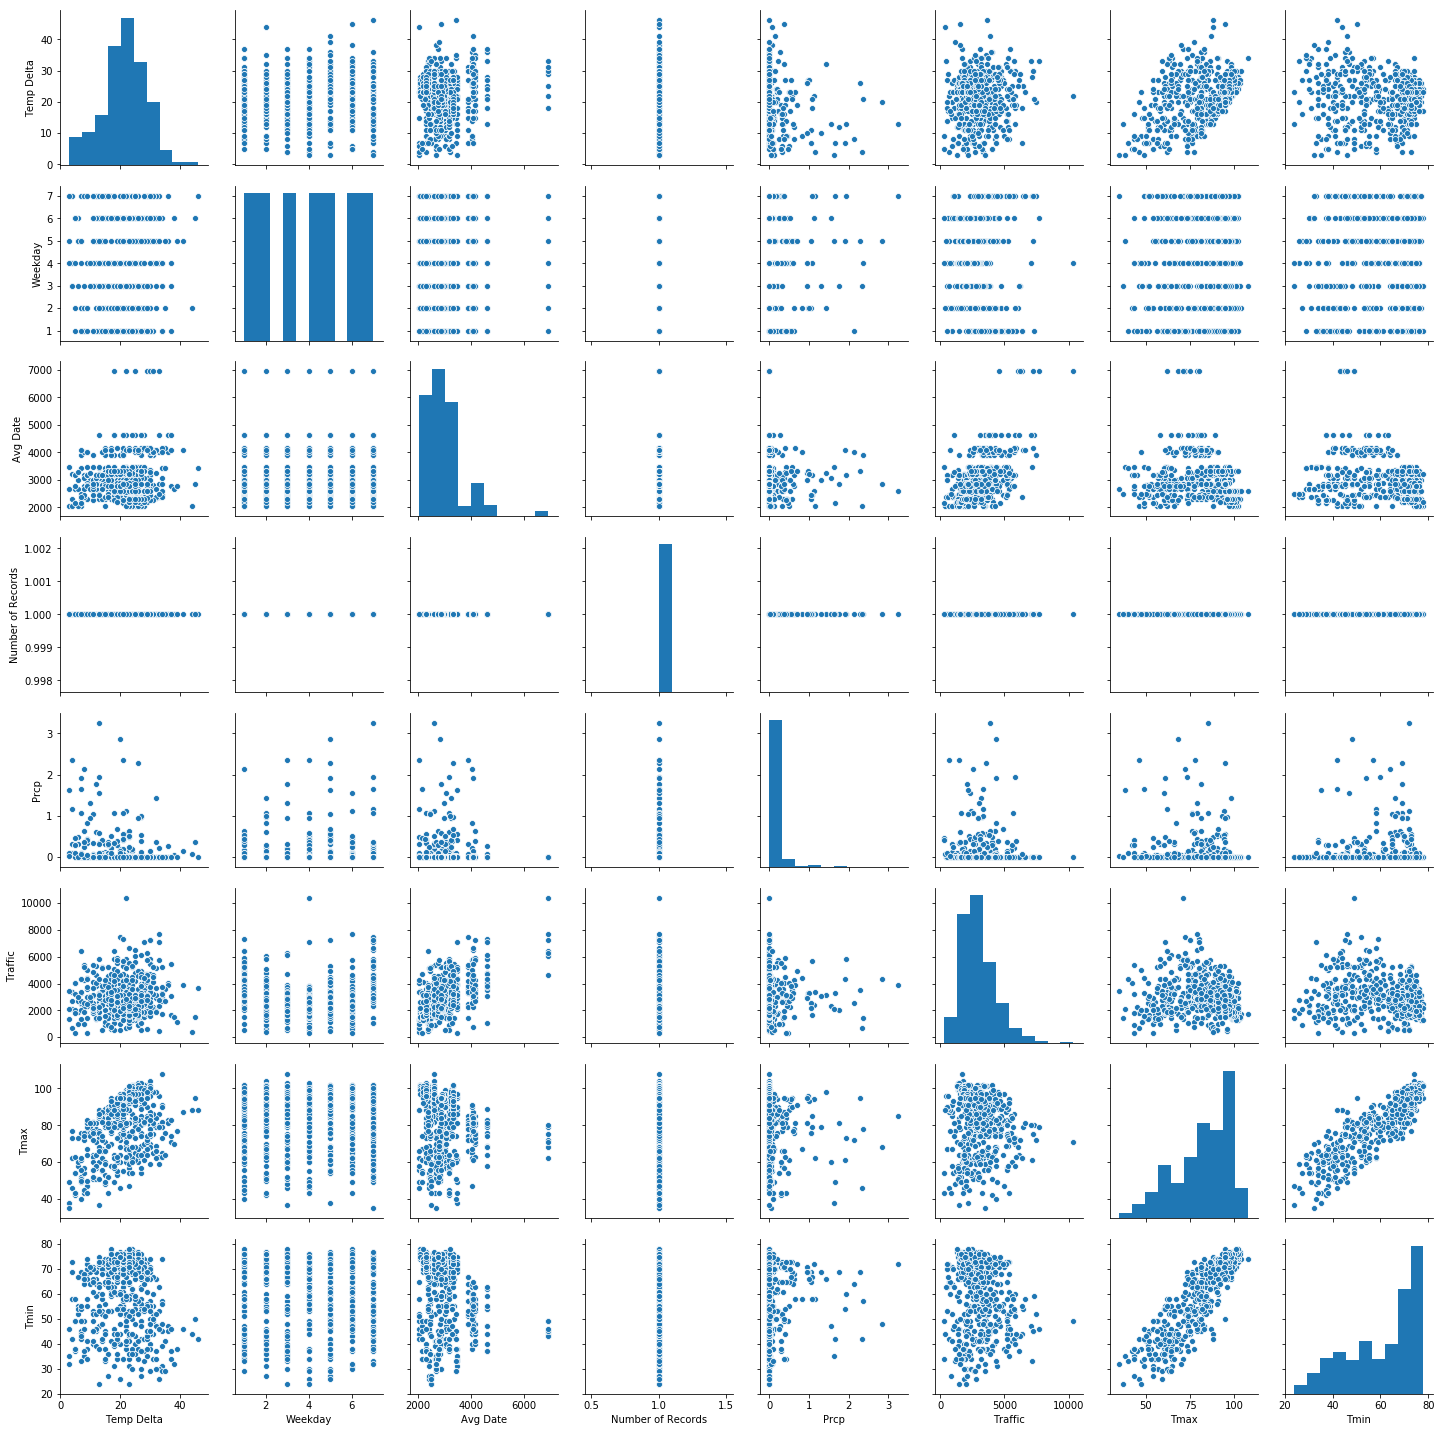

In [667]:
sns.pairplot(df_congress)

In [668]:
df_congress.columns

Index(['Temp Delta', 'Weekday', 'Avg Date', 'Date', 'Name',
       'Number of Records', 'Prcp', 'Trails', 'Traffic', 'Station', 'Tmax',
       'Tmin', 'Time'],
      dtype='object')

## 2.2 Make Features

In [669]:
# Store models to run in list to review later
#model_list = []

### 2.2.1 Temperature

In [670]:
# Multiply Temp max and min
df_congress['Temp_multi'] = df_congress['Tmin']*df_congress['Tmax']
# Multiply Temp max and min and then cube
df_congress['Temp_multi_cube'] = (df_congress['Tmin']*df_congress['Tmax'])**3

In [671]:
# Get month
df_congress['month'] = pd.DatetimeIndex(df_congress.Date).month

### 2.2.2 Dates

In [672]:
# Returns boolean of it's day is a weekend
def weekend_tag(weekday):
        if weekday == 1 or weekday == 7:
            return 1
        else:
            return 0

In [673]:
# Returns boolean of it's day is a weekend for flask
def weekend_tag_flask(weekday):
        if weekday == 5 or weekday == 6:
            return 1
        else:
            return 0

In [696]:
# Returns seasons (based on avg monthly Tmax temp groups)
def season_tag(month):
        #Months Tavg >90
        if month == 6 or weekday == 7 or weekday == 8 or weekday == 9:
            return 'Hot'
        #Months avg 70<Tavg<90 
        if month == 4 or month == 5 or month == 10:
            return 'Warm'
        #Months Tavg <70
        else:
            return 'Just Rught'

In [698]:
# Create columns in df
df_congress['Weekend'] = df_congress.Weekday.apply(lambda x: weekend_tag(x))
df_congress['Season'] = df_congress.month.apply(lambda x: season_tag(x))

### 2.2.3 Events

In [699]:
# Add Event flags
df_congress['Events'] = 0

### 2.2.x Outliers

In [700]:
df_congress.dropna(inplace=True)

In [701]:
# Remove high value
df_congress = df_congress[df_congress.Traffic != 10374]


---

In [737]:
# Possible Features
df_congress.columns

Index(['Temp Delta', 'Weekday', 'Avg Date', 'Date', 'Name',
       'Number of Records', 'Prcp', 'Trails', 'Traffic', 'Station', 'Tmax',
       'Tmin', 'Time', 'Temp_multi', 'Temp_multi_cube', 'month', 'Events',
       'Weekend', 'Season'],
      dtype='object')

In [738]:
# Features to run model on
features = ['Prcp','Tmax','Tmin','Temp_multi_cube','month','Weekday','Season','Weekend']

In [739]:
# Get dummies and set to split
X = pd.get_dummies(df_congress[features].dropna(), columns=['Season','Weekday','month'], drop_first=True)
X_tree = pd.get_dummies(df_congress[features].dropna(), columns=['Season','Weekday','month'])
y = (df_congress['Traffic'])

In [740]:
#Check Inputs
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 768 to 1334
Data columns (total 24 columns):
Prcp                 566 non-null float64
Tmax                 566 non-null float64
Tmin                 566 non-null float64
Temp_multi_cube      566 non-null float64
Weekend              566 non-null int64
Season_Just Rught    566 non-null uint8
Season_Warm          566 non-null uint8
Weekday_2            566 non-null uint8
Weekday_3            566 non-null uint8
Weekday_4            566 non-null uint8
Weekday_5            566 non-null uint8
Weekday_6            566 non-null uint8
Weekday_7            566 non-null uint8
month_2              566 non-null uint8
month_3              566 non-null uint8
month_4              566 non-null uint8
month_5              566 non-null uint8
month_6              566 non-null uint8
month_7              566 non-null uint8
month_8              566 non-null uint8
month_9              566 non-null uint8
month_10             566 non-null uint8
mont

## 3.x Run Models

In [741]:
def run_model_tts_regressor(model, X, y, test_size =.25, random_state=23):
    """
    This function takes an unfitted model, X values and Y values
    and returns a histogram of the residuals as well as a scatter plot
    of the true values against predictions.
    """

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    residuals = y_preds - y_test

    fig = plt.figure(figsize=(12,5))

    ax1 = plt.subplot(121)
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predictions")
    plt.scatter(y_test, y_preds);

    ax2 = plt.subplot(122)
    ax2.set_xlabel('True Values')
    ax2.set_ylabel('Residuals')
    plt.scatter(y_test,residuals);

    print('R2 Score:', model.score(X_test, y_test))
    print('     RMSE:', mean_squared_error(y_test, y_preds)**(1/2))
    print('     MAE:',mean_absolute_error(y_test,y_preds))
    
    
    return model,mean_squared_error(y_test, y_preds)**(1/2),mean_absolute_error(y_test,y_preds)

_Linear Regression_

R2 Score: 0.4588947324524181
     RMSE: 924.4249746682332
     MAE: 637.3487377944152


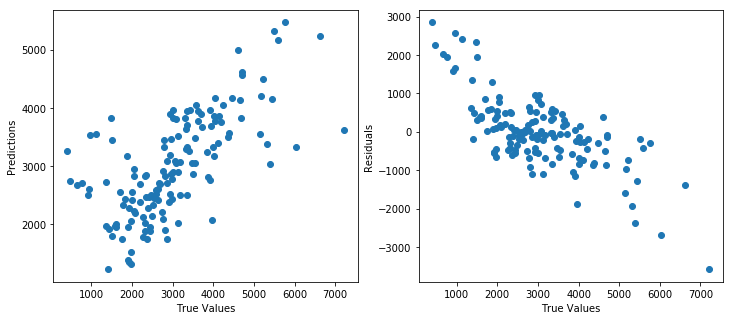

In [742]:
lr = run_model_tts_regressor(LinearRegression(), X, y)
model_list.append([lr[0],X.columns,lr[1],lr[2]])

In [743]:
pd.DataFrame(list(lr[0].coef_) + [lr[0].intercept_], index=list(X.columns) + ['Interecept'])

,0
Prcp,2.918647e+01
Tmax,3.385696e+01
Tmin,-1.755181e+00
Temp_multi_cube,-6.003609e-09
Weekend,1.181751e+03
Season_Just Rught,-4.381538e+02
Season_Warm,-2.820485e+00
Weekday_2,-2.341230e+02
Weekday_3,-3.218453e+02
Weekday_4,-4.833122e+02


_Gradient Boost_

R2 Score: 0.434990949946101
     RMSE: 944.6229468808953
     MAE: 704.4745508797369


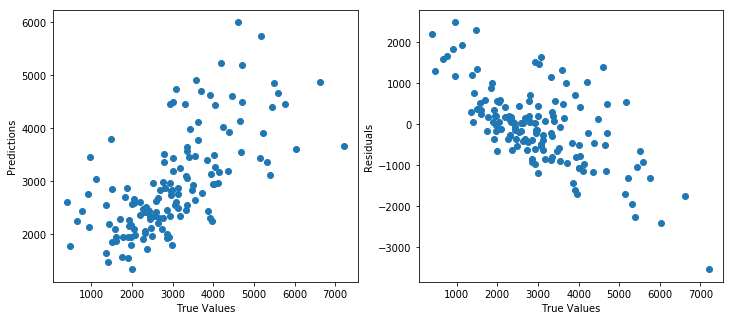

In [744]:
gbr = run_model_tts_regressor(GradientBoostingRegressor(), X, y)
model_list.append([gbr[0],X.columns,gbr[1],gbr[2]])

In [745]:
#Review Coefficients
pd.DataFrame(gbr[0].feature_importances_, index=X.columns)

,0
Prcp,0.046636
Tmax,0.117103
Tmin,0.115218
Temp_multi_cube,0.114909
Weekend,0.348884
Season_Just Rught,0.001549
Season_Warm,0.006084
Weekday_2,0.001200
Weekday_3,0.000901
Weekday_4,0.013210


_Random Forest_

R2 Score: 0.45865030253082395
     RMSE: 924.6337432996424
     MAE: 660.8277788026255


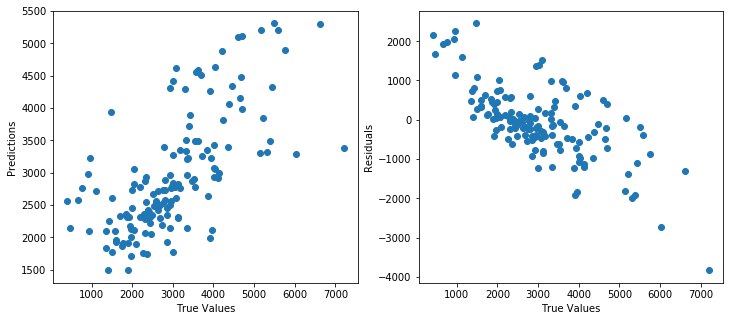

In [747]:
rf = run_model_tts_regressor(RandomForestRegressor(n_estimators=100, min_samples_leaf=5), X_tree, y)
model_list.append([rf[0],X_tree.columns,rf[1],rf[2]])

In [748]:
pd.DataFrame(rf[0].feature_importances_, index=X_tree.columns)

,0
Prcp,0.029578
Tmax,0.096777
Tmin,0.102899
Temp_multi_cube,0.128163
Weekend,0.391957
Season_Hot,0.005673
Season_Just Rught,0.007427
Season_Warm,0.015757
Weekday_1,0.003002
Weekday_2,0.001299


---
## Review Models Ran

In [749]:
df_models = pd.DataFrame(model_list,columns=['Model','Features','RSME','MAE'])

In [753]:
df_models = df_models.sort_values('MAE')

In [758]:
df_models.head(10)

,Model,Features,RSME,MAE
15,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Tmax', 'Temp_multi_cube', 'Wee...",914.320385,635.258311
21,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi_cub...",916.256666,636.619424
18,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi_cub...",916.256666,636.619424
30,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi_cub...",924.424975,637.348738
20,"(DecisionTreeRegressor(criterion='mse', max_de...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi_cub...",904.191120,641.784280
2,"(DecisionTreeRegressor(criterion='mse', max_de...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi', '...",908.297893,642.825198
29,"(DecisionTreeRegressor(criterion='mse', max_de...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi', '...",915.416508,647.593241
12,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Temp_multi_cube', 'Weekend', '...",909.853951,649.722677
0,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi', '...",931.976098,656.296231
9,"LinearRegression(copy_X=True, fit_intercept=Tr...","Index(['Prcp', 'Tmin', 'Tmax', 'Temp_multi', '...",939.421672,657.881601


In [734]:
df_models.loc[2]['Features']

Index(['Prcp', 'Tmax', 'Tmin', 'Temp_multi', 'Weekend', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

---
**EXPORT MODEL TO USE IN FLASK**

In [531]:
import pickle

In [532]:
pickle.dump(df_models.loc[2]["Model"],open("./congress_top_trail_model"+ datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+.pkl",'wb'))

## 4.1 Predict Tool

In [592]:
# Begin setup of model inputs into plotly
Precip = 0.1
Tmax = 80
Tmin = 50
Date = pd.to_datetime('2019-11-17')
Weekend = weekend_tag_flask(Date.weekday())
Month = Date.month

In [596]:
def weekend_tag_flask(weekday):
        if weekday == 5 or weekday == 6:
            return 1
        else:
            return 0

In [593]:
def month_boolean(month, inputs):
    for x in np.arange(1,13):
        if month == x:
            inputs.append(1)
        else:
            inputs.append(0)

In [594]:
Precip = 0.1
Tmax = 80
Tmin = 50
Date = pd.to_datetime('2019-11-17')
Weekend = weekend_tag_flask(Date.weekday())
Month = Date.month
inputs = [Precip, Tmax, Tmin, Tmax*Tmin, Weekend]
month_boolean(Month,inputs)

In [595]:
inputs

[0.1, 80, 50, 4000, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]